# MLflow avanzado: Optimización de hiperparámetros y registro de modelos
 
En este notebook, exploraremos algunas de las funciones más avanzadas de MLflow, incluyendo:

-   **Optimización de hiperparámetros:** Usar Optuna para encontrar los mejores hiperparámetros para nuestro modelo y registrar los resultados en MLflow.
-   **Registro de modelos:** Registrar el mejor modelo en el Registro de Modelos de MLflow para versionado y despliegue.

In [1]:
import os
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
import pickle

## **Cargamos datos "procesados"**

In [2]:
df_jan = pd.read_parquet("data/processed/jan.parquet")
df_feb = pd.read_parquet("data/processed/feb.parquet")


## **Definir columnas a modelar**

In [3]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ["trip_distance"]

## Definir set de train y test

In [4]:
df_train = df_jan
df_val = df_feb

## **Preprocesar**

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

df_train = df_train.copy()
df_val   = df_val.copy()
df_train["categorical_dict"] = df_train[categorical].to_dict(orient="records")
df_val["categorical_dict"]   = df_val[categorical].to_dict(orient="records")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", DictVectorizer(), "categorical_dict"),
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), numerical),
    ]
)

X_train = preprocessor.fit_transform(df_train)
y_train = df_train["duration"].values
X_val   = preprocessor.transform(df_val)
y_val   = df_val["duration"].values

## **Entrenar**

Antes de ejecutar lo siguiente correr en la terminal en la misma carpeta donde esta el notebook:

`mlflow server --backend-store-uri sqlite:///backend.db`



In [11]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [7]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://127.0.0.1:5000'


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

experiment_name = "rf-nyc-taxi"
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    rf = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

2025/09/08 14:50:18 INFO mlflow.tracking.fluent: Experiment with name 'rf-nyc-taxi' does not exist. Creating a new experiment.


🏃 View run popular-trout-980 at: http://127.0.0.1:5000/#/experiments/1/runs/428919abb7a24566a851d55e10b61a39
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


## **Probando otro modelo**

In [9]:
import xgboost as xgb

with mlflow.start_run():
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

🏃 View run hilarious-yak-674 at: http://127.0.0.1:5000/#/experiments/1/runs/9845ca249921401baeab76477a75138d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


## **Probando autologgin**

In [13]:
import mlflow

experiment_name = "rf-nyc-taxi-autolog"
mlflow.set_experiment(experiment_name)
mlflow.autolog()

with mlflow.start_run():
    rf = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)


2025/09/03 21:24:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/09/03 21:24:20 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 2.0.0 <= xgboost <= 3.0.2, but the installed version is 3.0.4. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/09/03 21:24:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2025/09/03 21:24:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run unleashed-wasp-528 at: http://127.0.0.1:5000/#/experiments/2/runs/a08c2f7a958346fc85961081092e58ec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


## **Optimización de Hiperparametros**

## **¿Por qué es importante la optimización de hiperparámetros?**

En ML, los hiperparámetros son como los “ajustes” que le damos a nuestros modelos antes de entrenarlos. Cosas como la cantidad de árboles en un Random Forest, la profundidad máxima, o la tasa de aprendizaje en un modelo de boosting. Elegir bien estos valores puede marcar la diferencia entre un modelo mediocre y uno realmente bueno.

Optimizar los hiperparámetros no es solo cuestión de probar al azar: es un proceso sistemático para encontrar la mejor combinación posible, y así lograr que nuestro modelo aprenda mejor y generalice bien a datos nuevos. Si no los ajustamos, podemos quedarnos con un modelo que no aprovecha todo su potencial.

## **Usando Optuna**

Para facilitar este proceso, existen herramientas como **Optuna**, que nos ayudan a buscar automáticamente los mejores hiperparámetros de manera eficiente e inteligente. Optuna prueba diferentes combinaciones, aprende de los resultados y se enfoca en las opciones más prometedoras, ahorrándonos mucho tiempo y esfuerzo.

En resumen: dedicarle tiempo a la optimización de hiperparámetros, usando herramientas como Optuna, es clave para sacar el máximo provecho de nuestros modelos de ML.

<img src="optim.png">

In [12]:
import optuna

mlflow.set_experiment("nyc-taxi-experiment-optuna")

def objective(trial):
    with mlflow.start_run():
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
            'max_depth': trial.suggest_int('max_depth', 1, 20, 1),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10, 1),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4, 1),
            'random_state': 42,
            'n_jobs': -1
        }
        mlflow.log_params(params)

        rf = RandomForestRegressor(**params)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)

    return rmse

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=10)

[I 2025-09-08 14:57:10,263] A new study created in memory with name: no-name-49fc3aa8-3f6a-4f9e-bfbf-98fdaafb1122
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_7213/1509556442.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_7213/1509556442.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprec

🏃 View run rebellious-grub-389 at: http://127.0.0.1:5000/#/experiments/2/runs/cbd7d8e7904b493584b107bf10cc7009
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_7213/1509556442.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_7213/1509556442.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the key

🏃 View run awesome-zebra-462 at: http://127.0.0.1:5000/#/experiments/2/runs/aec6d47e889744c69ea2ab60710391f2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


[I 2025-09-08 14:57:11,441] Trial 2 finished with value: 5.034253440524673 and parameters: {'n_estimators': 34, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 2 with value: 5.034253440524673.
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_7213/1509556442.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_7213/1509556442.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword ar

🏃 View run sneaky-bear-150 at: http://127.0.0.1:5000/#/experiments/2/runs/af27657581364d4aa74e566a463a7d0f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run enchanting-horse-827 at: http://127.0.0.1:5000/#/experiments/2/runs/1d11cfd682ec4165af78a83f237e410e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_7213/1509556442.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_7213/1509556442.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the key

🏃 View run polite-lynx-693 at: http://127.0.0.1:5000/#/experiments/2/runs/c551cbb4c5cc41cfa40d38d3c2ff61e1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run nimble-ram-265 at: http://127.0.0.1:5000/#/experiments/2/runs/eb0d719dae41466a89d1ea854b3e2e00
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_7213/1509556442.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_7213/1509556442.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the key

🏃 View run redolent-bird-241 at: http://127.0.0.1:5000/#/experiments/2/runs/75f52f47d42a4efbaaec04db71b54181
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run nimble-lynx-92 at: http://127.0.0.1:5000/#/experiments/2/runs/35fc9dab264b4fc1aba9d31b07cd9e46
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_7213/1509556442.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_7213/1509556442.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the key

🏃 View run trusting-calf-198 at: http://127.0.0.1:5000/#/experiments/2/runs/6ef7caca1174449b8ff032b3da13d559
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
🏃 View run popular-smelt-517 at: http://127.0.0.1:5000/#/experiments/2/runs/e05346b6c7e64464ac2bee614adc5217
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


## **Explorando la MLflow UI**

Ahora que hemos ejecutado la optimización, vamos a explorar la interfaz de MLflow:

1. **Experimentos**: Ve a la pestaña "Experiments" para ver todos los experimentos
2. **Runs**: Cada trial de Optuna aparece como un run individual
3. **Métricas**: Compara el RMSE de todos los trials
4. **Parámetros**: Ve cómo varían los hiperparámetros
5. **Model Registry**: Encuentra el modelo registrado en "Models"

### **Qué buscar en la UI:**
- El run con el menor RMSE (mejor modelo)
- La evolución de las métricas a lo largo de los trials
- La importancia de cada hiperparámetro
- Los artefactos del modelo registrado

## **Mejor modelo**

Cuando tenemos el mejor modelo, lo entrenamos de nuevo para despues usarlo.

In [15]:
# Analyze the best trial
print(f"Best trial: {study.best_trial.number}")
print(f"Best value (RMSE): {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Train the best model
best_params = study.best_params
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_val)
rmse_best = np.sqrt(mean_squared_error(y_val, y_pred_best))

print(f"\nBest model RMSE: {rmse_best:.4f}")

2025/09/03 22:00:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bd51c392fea6461ab55f2b415c3e4ce0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Best trial: 47
Best value (RMSE): 5.0312
Best params:
  n_estimators: 50
  max_depth: 14
  min_samples_split: 4
  min_samples_leaf: 2


2025/09/03 22:00:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run luxuriant-elk-509 at: http://127.0.0.1:5000/#/experiments/3/runs/bd51c392fea6461ab55f2b415c3e4ce0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3

Best model RMSE: 5.0250


## **Visualizando la optimización de optuna**

/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_38977/602149405.py:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

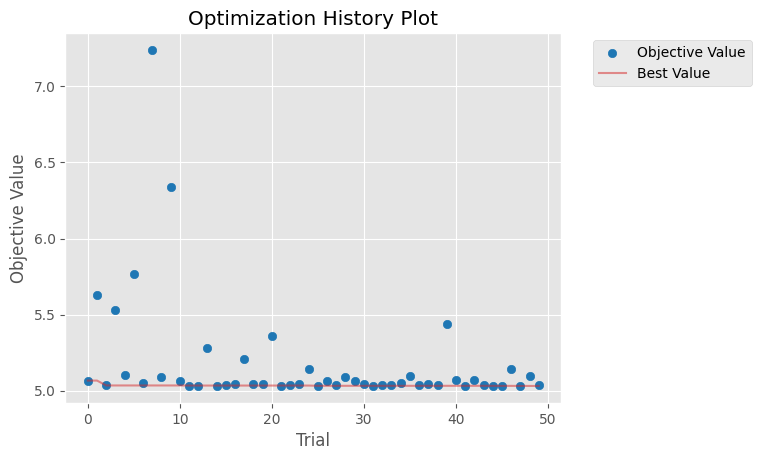

In [17]:
# Visualize optimization history
import matplotlib.pyplot as plt


# Optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)



/var/folders/02/7p49pcn90q5ftb99dns9v18c0000gp/T/ipykernel_38977/82623574.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
2025/09/03 22:02:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5d2d05490db74d9e8f05af63750e2eba', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/09/03 22:02:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run glamorous-elk-818 at: http://127.0.0.1:5000/#/experiments/3/runs/5d2d05490db74d9e8f05af63750e2eba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

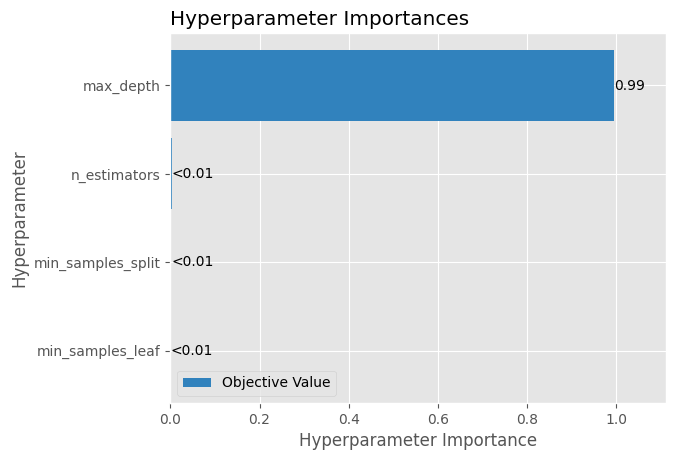

In [19]:
optuna.visualization.matplotlib.plot_param_importances(study)


# **Usando el model registry para guardar el mejor modelo y "ponerlo" en producción**

Podemos usar autlog de sklearn para captar la mayor cantidad de parametros y asi tener un modelo altamente replicable

La importancia del model registry es ya no solamente pensar en la experimentación, sino que al final, después de haber encontrado el mejor modelo pushearlo a nuestro model registry y poder usarlo en producción.

In [20]:
# Register the best model
with mlflow.start_run(run_id=study.best_trial.user_attrs.get('mlflow_run_id')):
    # Log the model
    mlflow.sklearn.log_model(
        best_model, 
        "model",
        registered_model_name="nyc-taxi-rf-optimized"
    )
    
    # Log preprocessing pipeline
    mlflow.sklearn.log_model(
        preprocessor, 
        "preprocessor",
        registered_model_name="nyc-taxi-preprocessor"
    )

2025/09/03 22:13:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/03 22:13:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/03 22:13:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'nyc-taxi-rf-optimized'.
2025/09/03 22:13:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: nyc-taxi-rf-optimized, version 1
Created version '1' of model 'nyc-taxi-rf-optimized'.
2025/09/03 22:13:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/03 22:13:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/09/0

🏃 View run overjoyed-wasp-649 at: http://127.0.0.1:5000/#/experiments/3/runs/25696e3de5aa4e53a9ddd4efcb225ca2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


Created version '1' of model 'nyc-taxi-preprocessor'.
